In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
os.listdir()

['BTC',
 'Deribir_Traiding',
 'BTC_perpetual',
 'BTC_snapshots',
 '.ipynb_checkpoints',
 'Trades Quotes Prices etc.pdf',
 'Deribit_Trading.ipynb']

In [3]:
with open('Deribir_Traiding', 'r') as file:
    lines = file.readlines()

In [4]:
columns = lines[0].replace('\n', '').split(',')
columns

['exchange',
 'symbol',
 'timestamp',
 'local_timestamp',
 'id',
 'side',
 'price',
 'amount']

In [5]:
def parse_data(data_lines):
    columns = data_lines[0].replace('\n', '').split(',')
    data_dict = {}
    for key in columns:
        data_dict[key] = []
        
    for i in range(1, len(data_lines)):
        data = data_lines[i].replace('\n', '').split(',')
        for idx, key in enumerate(columns):
            data_dict[key].append(data[idx])

    return columns, data_dict

In [6]:
columns, data_dict = parse_data(lines)

In [7]:
df = pd.DataFrame(data_dict)

In [8]:
df.dtypes

exchange           object
symbol             object
timestamp          object
local_timestamp    object
id                 object
side               object
price              object
amount             object
dtype: object

In [9]:
df.head()

,exchange,symbol,timestamp,local_timestamp,id,side,price,amount
0,deribit,BTC-PERPETUAL,1696204800632000,1696204800640191,265755079,buy,28002.5,10
1,deribit,BTC-PERPETUAL,1696204800632000,1696204800640191,265755080,buy,28003,200
2,deribit,BTC-PERPETUAL,1696204800632000,1696204800640191,265755081,buy,28004.5,100
3,deribit,BTC-PERPETUAL,1696204800632000,1696204800640191,265755082,buy,28004.5,10000
4,deribit,BTC-PERPETUAL,1696204800632000,1696204800640191,265755083,buy,28005,17690


In [10]:
df.drop(columns=['exchange', 'symbol', 'id'], inplace=True)

In [11]:
df.tail()

,timestamp,local_timestamp,side,price,amount
88079,1696291180587000,1696291180590726,sell,27512.5,130
88080,1696291186430000,1696291186436876,buy,27513,770
88081,1696291186434000,1696291186439328,buy,27513,2010
88082,1696291190346000,1696291190353858,buy,27516.5,690
88083,1696291199296000,1696291199304812,sell,27516,500


In [12]:
# заменим sell на -1 и buy на 1

d = {'buy': 1, 'sell': -1}
df['side'] = df['side'].map(d)
df.head()

,timestamp,local_timestamp,side,price,amount
0,1696204800632000,1696204800640191,1,28002.5,10
1,1696204800632000,1696204800640191,1,28003,200
2,1696204800632000,1696204800640191,1,28004.5,100
3,1696204800632000,1696204800640191,1,28004.5,10000
4,1696204800632000,1696204800640191,1,28005,17690


In [13]:
df.shape

(88084, 5)

In [14]:
# new_df = df.groupby(['timestamp'])['side', 'price', 'amount']
# new_df.head()

In [15]:
df = df.astype({'timestamp': 'int64', 'price': 'float32', 'amount': 'int32'})

In [16]:
volume_times_price = df['amount'] * df['price']
df.insert(loc = len(df.columns), column='volume_times_price', value = volume_times_price)

In [17]:
df.head()

,timestamp,local_timestamp,side,price,amount,volume_times_price
0,1696204800632000,1696204800640191,1,28002.5,10,280025.0
1,1696204800632000,1696204800640191,1,28003.0,200,5600600.0
2,1696204800632000,1696204800640191,1,28004.5,100,2800450.0
3,1696204800632000,1696204800640191,1,28004.5,10000,280045000.0
4,1696204800632000,1696204800640191,1,28005.0,17690,495408450.0


In [18]:
amounts = df.groupby(['timestamp'])['amount'].sum()
volumes_time_prices =  df.groupby(['timestamp'])['volume_times_price'].sum()
vwap = volumes_time_prices / amounts
vwap

timestamp
1696204800632000    28004.804464
1696204800662000    28005.000000
1696204800670000    28005.000000
1696204807373000    28005.000000
1696204808503000    28007.914297
                        ...     
1696291180587000    27512.500000
1696291186430000    27513.000000
1696291186434000    27513.000000
1696291190346000    27516.500000
1696291199296000    27516.000000
Length: 45872, dtype: float64

In [19]:
amounts_np = df.groupby(['timestamp'])['amount'].sum().to_numpy()

In [20]:
pd.to_datetime(df['timestamp'])

0       1970-01-20 15:10:04.800632
1       1970-01-20 15:10:04.800632
2       1970-01-20 15:10:04.800632
3       1970-01-20 15:10:04.800632
4       1970-01-20 15:10:04.800632
                   ...            
88079   1970-01-20 15:11:31.180587
88080   1970-01-20 15:11:31.186430
88081   1970-01-20 15:11:31.186434
88082   1970-01-20 15:11:31.190346
88083   1970-01-20 15:11:31.199296
Name: timestamp, Length: 88084, dtype: datetime64[ns]

In [21]:
amounts_np.shape

(45872,)

In [22]:
vwap_np = vwap.to_numpy()

In [23]:
# По каждому уникальному значению timestemp - нужно подсчитать количество цен, если они разные - то M0_1, иначе M0_0

date, counts = np.unique(df['timestamp'].to_numpy(), return_counts=True)
len(date), len(counts)

mo = np.where(counts == 1, 'MO_0', 'MO_1')
mo

array(['MO_1', 'MO_0', 'MO_0', ..., 'MO_0', 'MO_0', 'MO_0'], dtype='<U4')

In [24]:
time = pd.to_datetime(np.unique(df['timestamp']), unit='us') + pd.Timedelta(hours=3)
time

DatetimeIndex(['2023-10-02 03:00:00.632000', '2023-10-02 03:00:00.662000',
               '2023-10-02 03:00:00.670000', '2023-10-02 03:00:07.373000',
               '2023-10-02 03:00:08.503000', '2023-10-02 03:00:09.672000',
               '2023-10-02 03:00:10.470000', '2023-10-02 03:00:15.171000',
               '2023-10-02 03:00:15.322000', '2023-10-02 03:00:16.416000',
               ...
               '2023-10-03 02:59:37.003000', '2023-10-03 02:59:37.113000',
               '2023-10-03 02:59:37.114000', '2023-10-03 02:59:37.185000',
               '2023-10-03 02:59:37.196000', '2023-10-03 02:59:40.587000',
               '2023-10-03 02:59:46.430000', '2023-10-03 02:59:46.434000',
               '2023-10-03 02:59:50.346000', '2023-10-03 02:59:59.296000'],
              dtype='datetime64[ns]', length=45872, freq=None)

In [25]:
side = df.groupby(['timestamp'])['side'].mean().to_numpy()

In [26]:
df.head()

,timestamp,local_timestamp,side,price,amount,volume_times_price
0,1696204800632000,1696204800640191,1,28002.5,10,280025.0
1,1696204800632000,1696204800640191,1,28003.0,200,5600600.0
2,1696204800632000,1696204800640191,1,28004.5,100,2800450.0
3,1696204800632000,1696204800640191,1,28004.5,10000,280045000.0
4,1696204800632000,1696204800640191,1,28005.0,17690,495408450.0


In [27]:
new_df = pd.DataFrame({'time': time,
                       'side': side,
                       'amount': amounts_np,
                       'order_type': mo,
                       'vwap': vwap_np})

new_df = new_df.astype({'side': 'int32'})
new_df.head()

,time,side,amount,order_type,vwap
0,2023-10-02 03:00:00.632,1,28000,MO_1,28004.804464
1,2023-10-02 03:00:00.662,1,10650,MO_0,28005.000000
2,2023-10-02 03:00:00.670,1,17370,MO_0,28005.000000
3,2023-10-02 03:00:07.373,1,50,MO_0,28005.000000
4,2023-10-02 03:00:08.503,1,166680,MO_1,28007.914297


In [28]:
side = new_df['side'].to_numpy()

In [29]:
shifts = []
corrs = []
for shift in range(1, 101):
    shifts.append(shift)
    corr = ((side[:-shift] - np.mean(side[:-shift]))*(side[shift:] - np.mean(side[shift:]))).mean()
    corrs.append(corr)

Text(0.5, 1.0, 'sides correlation graph')

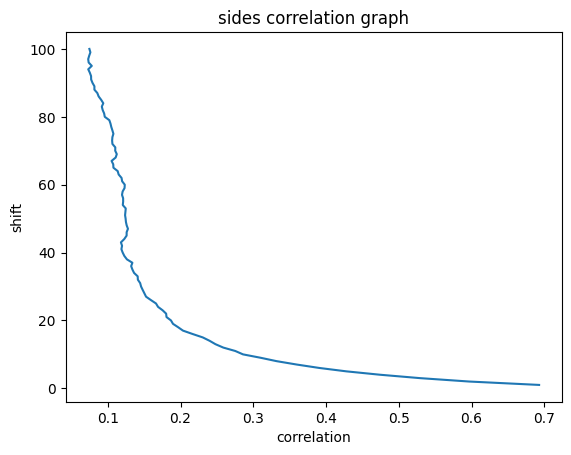

In [30]:
plt.plot(corrs, shifts)
plt.xlabel('correlation')
plt.ylabel('shift')
plt.title('sides correlation graph')

Text(0.5, 1.0, 'vwaps correlation graph')

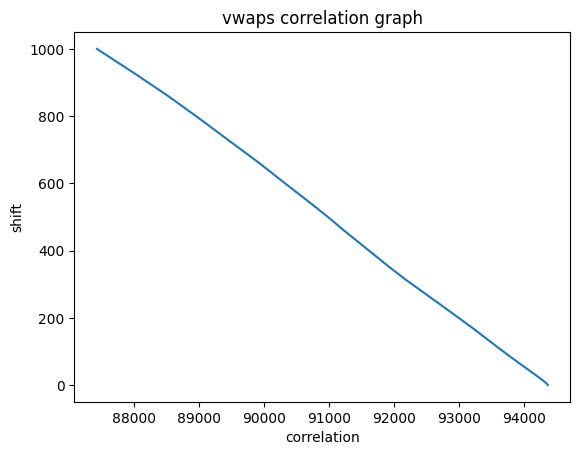

In [31]:
vwaps = new_df['vwap'].to_numpy()
corrs = []
shifts = []
for shift in range(1, 1001):
    shifts.append(shift)
    corr = ((vwaps[:-shift] - np.mean(vwaps[:-shift]))*(vwaps[shift:] - np.mean(vwaps[shift:]))).mean()
    corrs.append(corr)

plt.plot(corrs, shifts)
plt.xlabel('correlation')
plt.ylabel('shift')
plt.title('vwaps correlation graph')

Text(0.5, 1.0, 'amounts correlation graph')

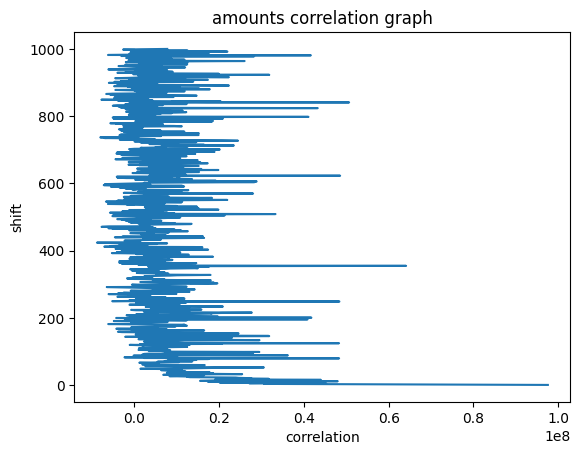

In [32]:
amounts = new_df['amount'].to_numpy()
corrs = []
shifts = []
for shift in range(1, 1001):
    shifts.append(shift)
    corr = ((amounts[:-shift] - np.mean(amounts[:-shift]))*(amounts[shift:] - np.mean(amounts[shift:]))).mean()
    corrs.append(corr)

plt.plot(corrs, shifts)
plt.xlabel('correlation')
plt.ylabel('shift')
plt.title('amounts correlation graph')

In [33]:
volumes = new_df['amount'].to_numpy()
volumes = np.sort(volumes)

In [34]:
indexes = np.linspace(0 ,len(volumes), 20, dtype=np.int32)

In [35]:
times = new_df['time'].to_numpy()
mid_prices = {}
for _time in times:
    mid_p = new_df[new_df['time'] == _time]['vwap'].mean()
    mid_prices[_time] = mid_p

In [223]:
# for a total dataset

volumes_count = []
expectations = []
expectation = 0
mean_volume = []
for i in range(1, len(indexes)):
    _volumes = volumes[indexes[i-1]:indexes[i]]
    _times = new_df[((new_df['amount'] >= _volumes[0]) & (new_df['amount'] <= _volumes[-1]))]['time'].to_numpy()
    _sides = new_df[((new_df['amount'] >= _volumes[0]) & (new_df['amount'] <= _volumes[-1]))]['side'].to_numpy()

    p = len(_times) / len(volumes)
    counter = 0
    for i in range(len(_times)-1):
        counter += _sides[i] * (mid_prices[_times[i]] - mid_prices[_times[i+1]])
        
    expectations.append(counter / (len(_times) - 1) * p)
    mean_volume.append(np.array(_volumes).mean())
    expectation += counter / (len(_times) - 1) * p

Text(0.5, 1.0, 'total expectation is -3.5050492668651465')

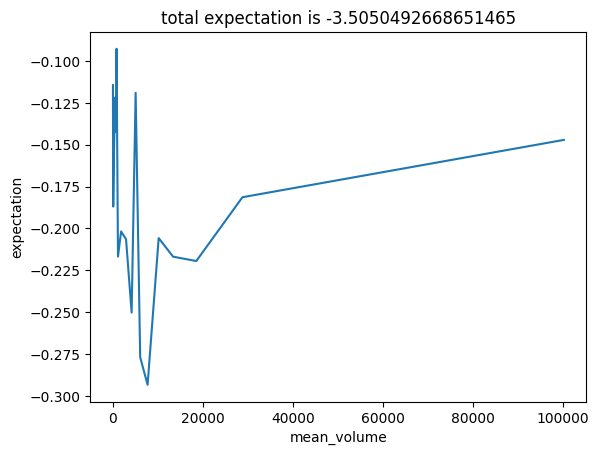

In [224]:
plt.plot(mean_volume, expectations)
plt.xlabel('mean_volume')
plt.ylabel('expectation')
plt.title(f'total expectation is {expectation}')

In [225]:
# second version


volume_points = []
expectations = []

for i in range(1, len(indexes)):
    _volumes = volumes[indexes[i-1]:indexes[i]]

    _unique_volumes, _volume_counts = np.unique(_volumes, return_counts=True)

    for _vol, _vol_count in zip(_volumes, _volume_counts):
        _times = new_df[new_df['amount'] == _vol]['time'].to_numpy()
        _sides = new_df[new_df['amount'] == _vol]['side'].to_numpy()

        p = _vol_count / len(_volumes)
        counter = 0
        for i in range(len(_times)-1):
            counter += _sides[i] * (mid_prices[_times[i]] - mid_prices[_times[i+1]])

        _expect = counter / (len(_times) - 1) * p if len(_times) > 1 else counter * p
        expectations.append(_expect)
        volume_points.append(_vol)

Text(0.5, 1.0, 'total expectation is -3.5050492668651465')

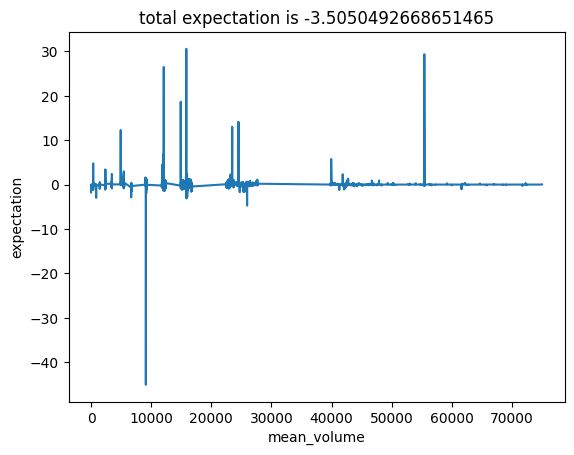

In [226]:
plt.plot(volume_points, expectations)
plt.xlabel('mean_volume')
plt.ylabel('expectation')
plt.title(f'total expectation is {expectation}')

In [ ]:
# corr(v_MO_t, v_LO)

# BTC_snapshots - состояние стакана

# with open('BTC_snapshots', 'r') as file:
#     lines = file.readlines()

In [39]:
mid_prices_list = []
for key in list(mid_prices.keys()):
    mid_prices_list.append(mid_prices[key])

mid_prices_list = np.array(mid_prices_list)

In [42]:
mid_prices_list.shape
sides = new_df['side'].to_numpy()

In [43]:
# m_t = m_0 + \Sigma(G(t-n)\epsilon_n)

from sklearn.linear_model import LinearRegression

In [58]:
model = LinearRegression()

In [70]:
trainX = [sides[i:1000+i] for i in range(1000)]
trainY = [mid_prices_list[999 + i] - mid_prices_list[i] for i in range(1000)]

In [71]:
res = model.fit(trainX,  trainY)

In [72]:
# res.score(,)
res.coef_

array([ 2.46034892e+00,  3.29382067e+00,  3.84049602e+00,  8.27146159e-01,
        1.94268627e-01,  2.20397862e+00,  1.36711589e+00, -3.64826310e-02,
       -5.12226786e-01, -2.42591590e+00, -1.67535061e+00, -1.37921433e+00,
       -5.15282745e-01, -1.28044379e+00,  6.99089832e-01, -1.24734316e+00,
        1.22768292e+00,  3.61248386e+00,  1.84795962e+00,  4.84510122e+00,
        2.23468128e+00,  2.08768479e+00,  1.31872643e+00,  1.76388505e+00,
       -3.39420367e-01, -1.13482742e+00, -8.92173686e-01, -6.77737774e-02,
        1.72510675e+00,  1.49873424e+00,  5.01242906e-01,  2.03872727e+00,
        1.58622156e+00,  2.88139006e+00,  2.02303799e+00,  2.60320129e+00,
       -7.26629746e-01, -2.27488761e-01, -1.32300795e+00, -1.15297229e+00,
       -7.16676007e-02, -1.09513796e+00, -2.06122159e+00, -2.19449899e+00,
        2.03839863e+00, -2.41380072e+00,  1.86311283e+00,  3.92771470e-01,
        1.46004329e+00,  1.36921060e+00,  2.37778935e+00,  5.17327745e-01,
        4.16187256e+00,  

In [73]:
res.predict([sides[:1000], sides[1:1001], sides[2:1002]])

array([-11.80446429, -12.        , -12.        ])

In [74]:
[mid_prices_list[999] - mid_prices_list[0],
mid_prices_list[1000] - mid_prices_list[1],
mid_prices_list[1001] - mid_prices_list[2]]

[-11.804464285713038, -12.0, -12.0]

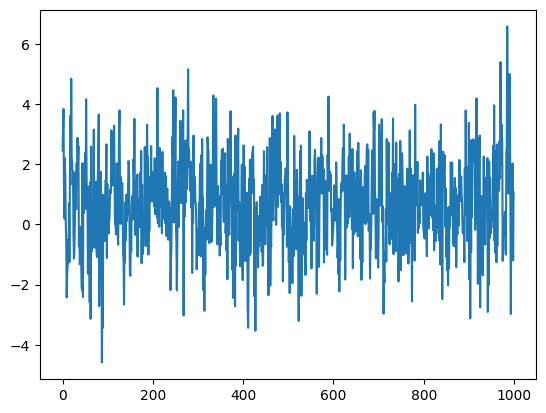

In [75]:
plt.plot(res.coef_)

In [96]:
C_l = [(sides[:1000] * sides[i+1:1000 + i + 1]).mean() for i in range(1000)]
S_l = [((np.array(mid_prices_list[:1000]) - np.array(mid_prices_list[i+1:1000+i+1])) * sides[:1000]).mean() for i in range(1000)]

In [97]:
G_s = np.zeros(1000)

In [98]:
C_matrix = np.zeros((1000, 1000))
                    
for i in range(1000):
    for j in range(1000):
        C_matrix[i, j] = C_l[np.abs(i-j)]

In [105]:
# K_vec = np.dot(np.linalg.inv(C_matrix), np.array(S_l).T)
K_vec = np.dot(C_matrix.T, np.array(S_l))

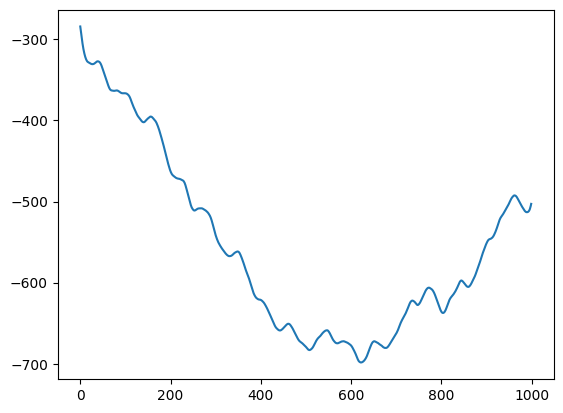

In [109]:
plt.plot(K_vec)
# plt.plot(np.cumsum(K_vec))

In [ ]:
lags = 100
rets = -np.log(pd.DataFrame(price, columns=['ret_0'])).diff(-1).dropna()
rets = rets.join(pd.DataFrame.from_records({f'ret_{l}':rets.ret_0.shift(-l) for l in range(1, lags + 1)}).loc[:, [f'ret_{l}' for l in range(1, lags + 1)]])
rets

side = pd.DataFrame(eps, columns=['eps_0'])
side = side.join(pd.DataFrame.from_records({f'eps_{l}':side.eps_0.shift(-l) for l in range(1, lags + 1)}).loc[:, [f'eps_{l}' for l in range(1, lags + 1)]])
side

S = rets.multiply(side.eps_0, axis=0).mean().values
c = side.multiply(side.eps_0, axis=0).mean().values
C = np.empty((lags + 1, lags + 1))
for i in range(lags + 1):
    for j in range(lags + 1):
        C[i, j] = c[abs(i - j)]
        
K = lin.inv(C).dot(S)
G_est = np.cumsum(np.concatenate(([0], K)))